In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg

# Helper functions

In [2]:
def construct_laplacian_kernel_matrix(N, h):
    # Construct the matrix that defines the linear system

    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)
    
    kernel_matrix = np.zeros((N ** 2, N ** 2), dtype=np.float32)
    kernel_matrix[rows, cols] = values

    return kernel_matrix

# Simple solver

In [3]:
def simple_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the matrix that defines the linear system
    kernel_matrix = construct_laplacian_kernel_matrix(N, h)
    
    # Cast vorticity to the required form
    w = -w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    
    # Solve the sparse linear system
    psi = np.linalg.solve(kernel_matrix, w)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


# Sparse solver

In [4]:
def sparse_solver(w):
    N = w.shape[0] - 2
    nx = N + 2
    ny = N + 2 # = nx

    h = 1 / (N + 1)
    
    # Construct the sparse matrix
    rows = []
    cols = []
    values = []
    
    for i in range(N):
        for j in range(N):
            rows.append(N * i + j)
            cols.append(N * i + j)
            values.append(-4 / h ** 2)
            
            if i - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * (i - 1) + j)
                values.append(1 / h ** 2)

            if j - 1 >= 0:
                rows.append(N * i + j)
                cols.append(N * i + (j - 1))
                values.append(1 / h ** 2)

            if i + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * (i + 1) + j)
                values.append(1 / h ** 2)

            if j + 1 <= N - 1:
                rows.append(N * i + j)
                cols.append(N * i + (j + 1))
                values.append(1 / h ** 2)

    # Create the sparse matrix from the above information
    kernel_matrix_sparse = sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))
    
    # Cast the dense vorticity matrix to sparse
    w = sparse.csr_matrix(-w[1:-1, 1:-1].flatten().reshape((N ** 2, 1)))
    
    # Solve the sparse linear system
    psi = sparse.linalg.spsolve(kernel_matrix_sparse, w).astype(np.float32)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


# Gauss-Seidel with SOR

In [5]:
def gauss_seidel_with_sor_solver(w, r=None):
    N = w.shape[0] - 1
    nx = N + 1
    ny = N + 1 # = nx

    h = 1 / N

    # SOR parameter
    if r is None:
        r = 2 / (1 + np.pi / N) # optimal value

    psi = np.zeros((nx, ny), dtype=np.float32) # initialize the streamfunction

    N_ITERATIONS = 4 * nx
    for iteration in range(1, N_ITERATIONS + 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] + psi[i, j - 1] + psi[i, j + 1] + w[i, j] * h ** 2
                ) / 4

    return psi

In [6]:
# Initialize grid and the value of the vorticity on it
nx = ny = 21
h = 1 / 20
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
w = w.astype(np.float32)

# Solve the system
psi_1 = simple_solver(w)
psi_2 = sparse_solver(w)
psi_3 = gauss_seidel_with_sor_solver(w)

In [7]:
psi_1.dtype, psi_2.dtype, psi_3.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [8]:
np.allclose(psi_1, psi_2), np.allclose(psi_1, psi_3), np.allclose(psi_2, psi_3)

(True, True, True)

In [9]:
psi = psi_2

In [10]:
abs_err = 0
for i in range(nx):
    for j in range(ny):
        abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)

print(f"abs_err = {abs_err}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

abs_err = 0.002058744430541992; psi(0.5, 0.5) = 1.002058744430542


In [11]:
abs_err = np.max(np.abs(psi - np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)))
abs_err

0.002058744430541992

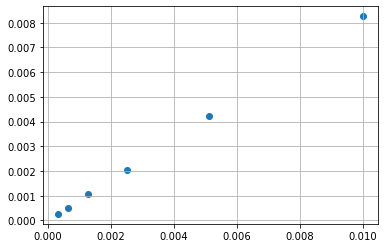

In [12]:
# error dependence on h

errors = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    nx = ny = N_value + 1
    h = 1 / N_value
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
    
    psi = sparse_solver(w)                
    
    abs_err = 0
    for i in range(nx):
        for j in range(ny):
            abs_err = max(abs(psi[i, j] - np.sin(np.pi * i * h) * np.sin(np.pi * j * h)), abs_err)
    errors.append(abs_err)
    
plt.scatter(1 / N_values ** 2, errors)
plt.grid()
# plt.legend()
plt.show()    

In [13]:
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, errors, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266453796876886 +- 2.723632164160623e-07


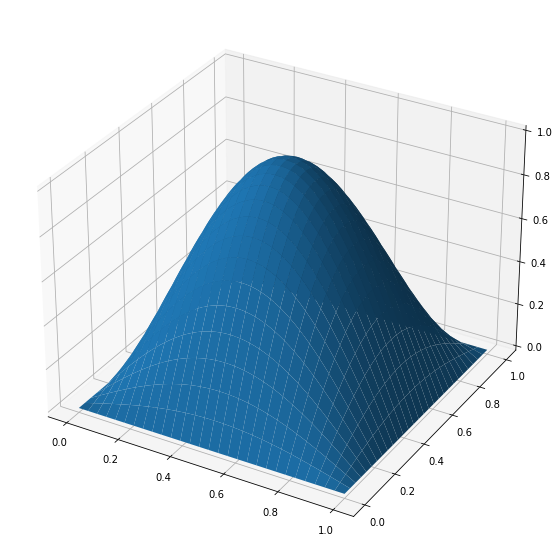

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

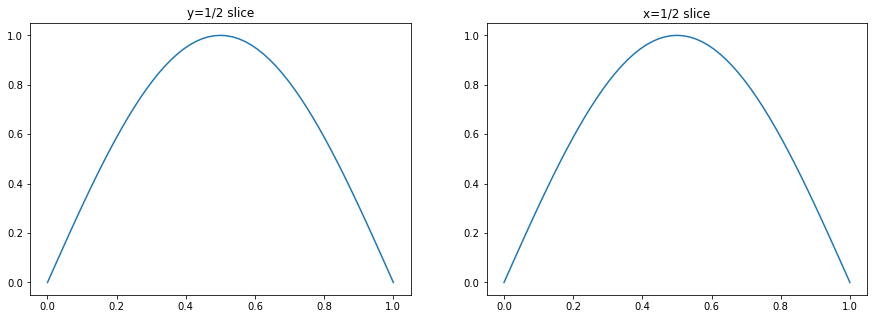

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[0, :], psi[:, ny // 2])
ax1.set_title("y=1/2 slice")
ax2.plot(y_grid[:, 0], psi[nx // 2, :])
ax2.set_title("x=1/2 slice")

plt.show()

In [16]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((28, 28), 1.0002623)

In [17]:
# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
nx = ny = 21
h = 1 / 20
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
w = np.zeros((nx, ny)) # vorticity

# Solve the system
psi_1 = simple_solver(w)
psi_2 = sparse_solver(w)
psi_3 = gauss_seidel_with_sor_solver(w)

np.any(psi_1), np.any(psi_2), np.any(psi_3)

(False, False, False)

# Speed comparison

100
CPU times: user 9min 39s, sys: 36.6 s, total: 10min 16s
Wall time: 5min 12s


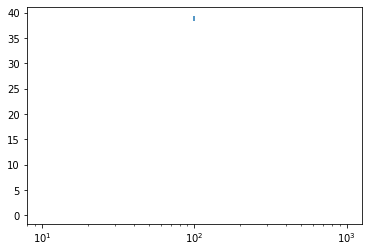

In [18]:
%%time
time_simple = []
errors_simple = []

time_sparse = []
errors_sparse = []

time_gs = []
errors_gs = []

# N_values = np.array([10, 14, 20, 28, 40, 56, 100, 1000, 10000, int(1e6)])
# N_values = np.array([10, 14, 20, 28, 40, 56, 100])
N_values = np.array([10, 14, 20, 28, 40, 56, 100, 180])
N_values = np.array([100, 180])
N_values = np.array([100])
# N_values = np.array([10, 14, 20, 28])

for N in N_values:
    print(N)
    
    nx = ny = N + 1
    h = 1 / N
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
    x_grid = x_grid.astype(np.float32)
    y_grid = y_grid.astype(np.float32)
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
    w = w.astype(np.float32)
    
    # simple
    time = %timeit -o -q simple_solver(w)
    time_simple.append(time.average)
    errors_simple.append(time.stdev)
    
    # sparse
    time = %timeit -o -q sparse_solver(w)
    time_sparse.append(time.average)
    errors_sparse.append(time.stdev)
    
#     # gs
#     time = %timeit -o -q gauss_seidel_with_sor_solver(w)
#     time_gs.append(time.average)
#     errors_gs.append(time.stdev)
    
plt.errorbar(x=N_values, y=time_simple, yerr=errors_simple)
plt.errorbar(x=N_values, y=time_sparse, yerr=errors_sparse)
# plt.errorbar(x=N_values, y=time_gs, yerr=errors_gs)
plt.xscale("log");

In [19]:
import pandas as pd

def df_from_performance_metrics(N_values, times, errors):
    return pd.DataFrame({
        "N": N_values,
        "time": times,
        "std": errors,
    })

df = df_from_performance_metrics(N_values, time_sparse, errors_sparse)
df.to_csv("times_sparse.csv", index=False)

df = df_from_performance_metrics(N_values, time_simple, errors_simple)
df.to_csv("times_simple.csv", index=False)

# df = df_from_performance_metrics(N_values, time_gs, errors_gs)
# df.to_csv("times_gs.csv", index=False)

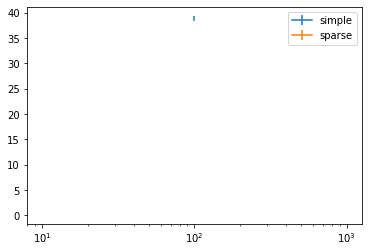

In [20]:
# for solver in ["simple", "sparse", "gs"]:
for solver in ["simple", "sparse"]:
    df = pd.read_csv(f"times_{solver}.csv")
    plt.errorbar(x=df["N"], y=df["time"], yerr=df["std"], label=solver)
    
plt.legend()
plt.xscale("log")